In [1]:
!pip install -U ultralytics wandb
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 13.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 67.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.18.3
    Uninstalling wandb-0.18.3:
      Successfully uninstalled wandb-0.18.3


In [2]:
from collections import defaultdict
import cv2
import numpy as np
import time
import json
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors
import os
import torch
from PIL import Image
from pathlib import Path
import cv2
import os
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import timm
import os
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from PIL import Image, ImageOps
import os


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
video_folder = '/kaggle/input/aerdjg/public_test/12fps/videos'
video_files = [f for f in os.listdir(video_folder) if f.endswith(('.mp4'))]
output_folder = '/kaggle/working/frames/'
os.makedirs(output_folder, exist_ok=True)

for idx, video_file in enumerate(video_files, start=1):
    video_path = os.path.join(video_folder, video_file)
    cap = cv2.VideoCapture(video_path)
    print(idx)
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if ret:
            output_image_path = os.path.join(output_folder, f'video_{idx}_frame_{frame_count}.jpg')
            cv2.imwrite(output_image_path, frame)
            frame_count += 1
        else:
            print(frame_count)
            break
    
    cap.release()

print("Кадры успешно извлечены и сохранены.")


1
4680
2
4680
3
4680
4
4680
5
4680
Кадры успешно извлечены и сохранены.


In [7]:
frame

Обработка фрейма 1


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


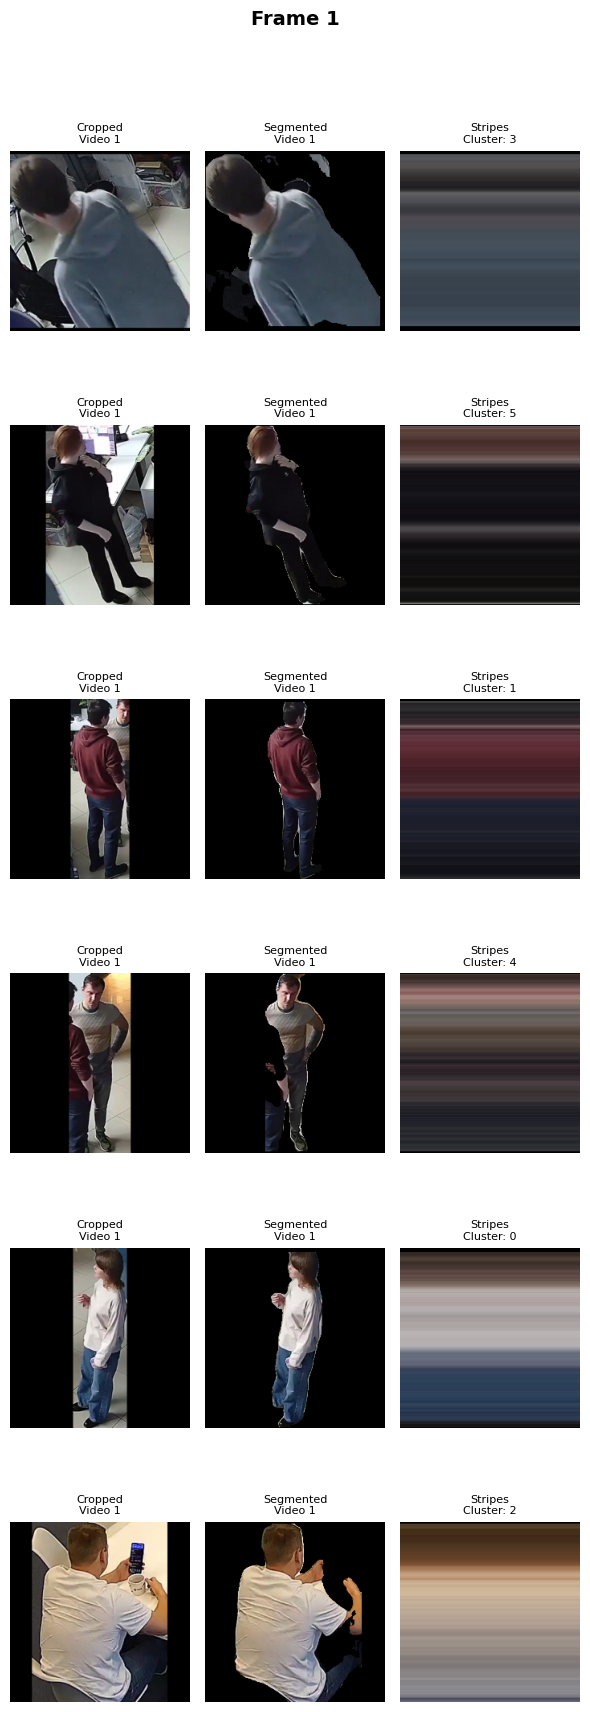

Обработка фрейма 2
Сегментация не обнаружила объектов на изображении: /kaggle/working/frames/video_4_frame_2.jpg


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


IndexError: index 6 is out of bounds for axis 0 with size 6

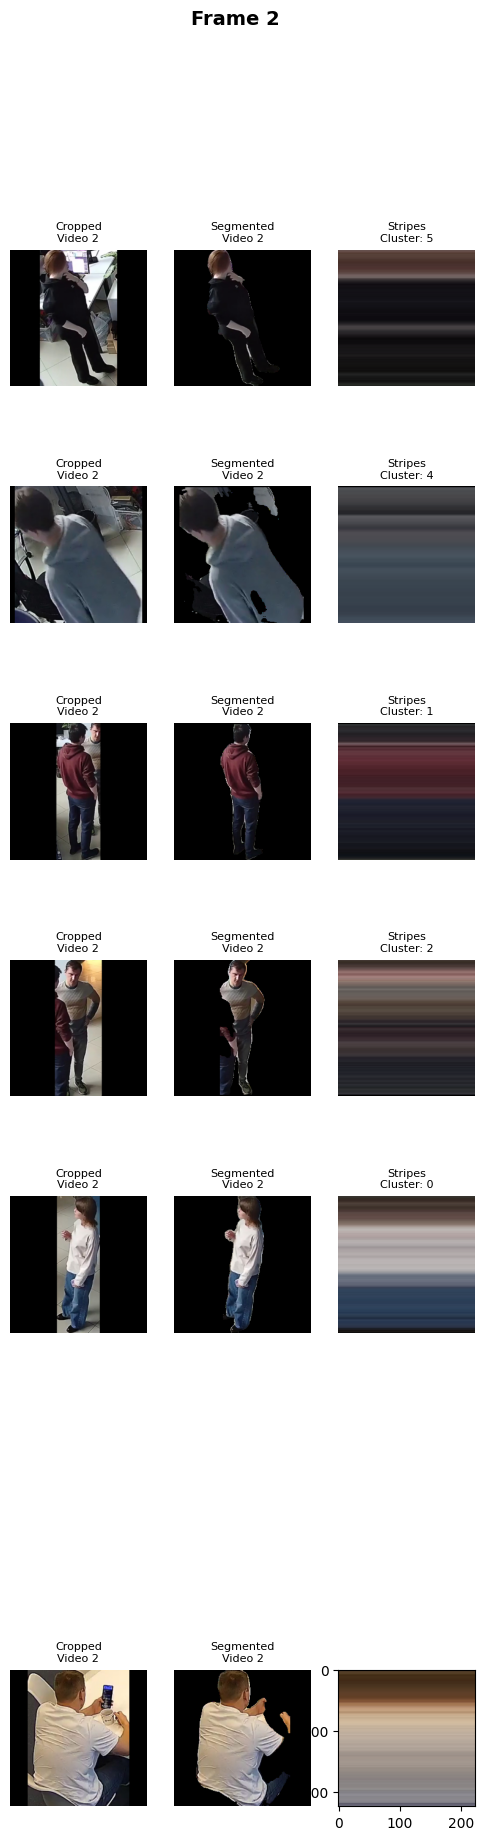

In [109]:
import os
import numpy as np
from PIL import Image
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from collections import defaultdict

def get_frames_from_folder(folder, num_videos=5):
    frame_dict = [[] for _ in range(num_videos)]
    
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            video_id, frame_id = filename.split('_')[0], int(filename.split('_')[3].split('.')[0])  # video_X_frame_Y
            if 1 <= frame_id <= len(frame_dict):
                frame_dict[frame_id - 1].append(os.path.join(folder, filename))
    
    return frame_dict


def predict_in_folders(yolo_model_path, image_paths, output_classes=[0]):
    yolo_model = YOLO(yolo_model_path)
    detection_data = []
    
    results = yolo_model.predict(
        source=image_paths,
        save=False,
        classes=output_classes,
        device="cuda" if torch.cuda.is_available() else "cpu",
        verbose=False  # Отключаем сообщения от YOLO
    )
    
    for result in results:
        image_path = result.path
        for idx, box in enumerate(result.boxes.xyxy):
            bbox = box.cpu().numpy().tolist()
            detection_data.append({
                "image_path": image_path, 
                "bbox": bbox, 
                "id": f"{image_path}_{idx}"
            })
    
    return detection_data


def crop_objects(detection_data, target_size=(224, 224)):
    cropped_data = []
    seen_ids = set()

    for detection in detection_data:
        image_path = detection["image_path"]
        bbox = detection["bbox"]
        person_id = detection["id"]

        if person_id not in seen_ids:
            seen_ids.add(person_id)
    
            try:
                with Image.open(image_path) as img:
                    x_min, y_min, x_max, y_max = map(int, bbox)
                    cropped = img.crop((x_min, y_min, x_max, y_max))
                    cropped = make_square(cropped)
                    cropped_resized = cropped.resize(target_size)
                    
                    cropped_data.append({
                        "cropped_image": cropped_resized,
                        "image_path": image_path,
                        "bbox": bbox,
                        "id": person_id
                    })
            except Exception as e:
                print(f"Ошибка обработки файла {image_path}: {e}")

    return cropped_data


def make_square(image):
    width, height = image.size
    size = max(width, height)
    new_image = Image.new("RGB", (size, size), (0, 0, 0))  # Черный фон
    new_image.paste(image, ((size - width) // 2, (size - height) // 2))
    return new_image


def segment_cropped_images_in_memory(segmentation_model_path, cropped_data, target_size=(224, 224)):
    segmentation_model = YOLO(segmentation_model_path)
    segmented_data = []
    seen_ids = set()

    for item in cropped_data:
        cropped_image = np.array(item["cropped_image"].convert("RGB"))
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)

        results = segmentation_model.predict(
            source=cropped_image,
            save=False,
            classes=[0],  # Ограничиваем только классом 0 (человек)
            device="cuda" if torch.cuda.is_available() else "cpu",
            verbose=False  # Отключаем сообщения от YOLO
        )

        if not results or not hasattr(results[0], "masks") or results[0].masks is None:
            print(f"Сегментация не обнаружила объектов на изображении: {item['image_path']}")
            continue
        else:
            person_id = item["id"]
            mask = results[0].masks.data[0]
            mask_array = mask.cpu().numpy()
            mask_array = (mask_array * 255).astype(np.uint8)

            if mask_array.shape[:2] != cropped_image.shape[:2]:
                mask_array = cv2.resize(mask_array, (cropped_image.shape[1], cropped_image.shape[0]))

            color_mask = cv2.cvtColor(mask_array, cv2.COLOR_GRAY2RGB)
            masked_image = cv2.bitwise_and(cropped_image, color_mask)
            masked_resized = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
            masked_resized = cv2.resize(masked_resized, target_size)

            segmented_data.append({
                "segmented_image": masked_resized,
                "image_path": item["image_path"],
                "bbox": item["bbox"],
                "id": item["id"]
            })

    return segmented_data


def process_lines_and_generate_stripes(segmented_data, target_size=(224, 224)):
    stripe_images = []
    color_data = []

    for item in segmented_data:
        segmented_image = item["segmented_image"]
        height, width, _ = segmented_image.shape

        stripe_image = np.zeros_like(segmented_image)

        for y in range(height):
            line = segmented_image[y, :, :]
            non_black_pixels = line[line[:, 0] != 0]  # Игнорируем черные пиксели

            if len(non_black_pixels) > 0:
                avg_color = np.mean(non_black_pixels, axis=0)
                stripe_image[y, :, :] = avg_color

        stripe_image_resized = cv2.resize(stripe_image, target_size)
        stripe_images.append({
            "stripe_image": stripe_image_resized,
            "image_path": item["image_path"],
            "bbox": item["bbox"],
            "id": item["id"]
        })

        # Добавляем средний цвет для кластеризации
        color_data.append(np.mean(stripe_image, axis=(0, 1)))  # Средний цвет по всему изображению

    return stripe_images, np.array(color_data)


def perform_clustering(color_data, num_clusters=6):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit_predict(color_data)
    return clusters


def visualize_steps(cropped_data, segmented_data, stripe_images, frame_id, video_id, clusters):
    """
    Визуализирует результаты: вырезанное изображение, сегментированное изображение и полоски.
    Для каждого человека отдельный столбик, все изображения выстроены по одной строке.
    """
    num_people = len(cropped_data)
    plt.figure(figsize=(6, 3 * num_people))  # Сжимаем по оси X и увеличиваем по оси Y

    # Заголовок для текущего кадра
    plt.suptitle(f"Frame {frame_id + 1}", fontsize=14, fontweight='bold')

    # Для каждого человека показываем картинку и ее сегментацию и полоски
    for i, item in enumerate(cropped_data):
        segmented_image = next((seg for seg in segmented_data if seg["id"] == item["id"]), None)
        stripe_image = next((stripe for stripe in stripe_images if stripe["id"] == item["id"]), None)

        if segmented_image and stripe_image:
            # Подпись с номером видео и ID человека
            person_label = f"Video {video_id}"

            # Вырезанное изображение
            plt.subplot(num_people, 3, 3 * i + 1)
            plt.imshow(item["cropped_image"])
            plt.title(f"Cropped\n{person_label}", fontsize=8)
            plt.axis('off')

            # Сегментированное изображение
            plt.subplot(num_people, 3, 3 * i + 2)
            plt.imshow(segmented_image["segmented_image"])
            plt.title(f"Segmented\n{person_label}", fontsize=8)
            plt.axis('off')

            # Полоски (цветовая карта)
            plt.subplot(num_people, 3, 3 * i + 3)
            plt.imshow(stripe_image["stripe_image"])
            plt.title(f"Stripes\nCluster: {clusters[i]}", fontsize=8)
            plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Убираем лишние пробелы между изображениями
    plt.show()


def perform_dynamic_clustering(stripe_images, color_data, max_stripe_len_so_far):
    num_images = len(stripe_images)  # Количество изображений в кадре
    num_clusters = max(num_images, max_stripe_len_so_far)  # Минимальное количество кластеров = max(текущая длина, максимальная длина за все кадры)
    
    # Кластеризация по цветам полосок
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit_predict(color_data)
    
    # Обновляем максимальную длину stripe_images, если текущий кадр имеет больше изображений
    new_max_stripe_len = max(max_stripe_len_so_far, num_images)
    
    return clusters, new_max_stripe_len


# Параметры
frames_folder = "/kaggle/working/frames"  # Папка с сохраненными кадрами
yolo_model_path = "yolo11n.pt"
segmentation_model_path = "yolo11n-seg.pt"
num_videos = 5  # Количество видео

# Чтение изображений из папки frames, группировка по номерам фреймов для нескольких видео
frame_dict = get_frames_from_folder(frames_folder, num_videos=num_videos)

max_stripe_len_so_far = 0  # Изначально максимальная длина = 0

# Обработка каждого фрейма по очереди для всех видео
for frame_id in range(4):  # Можно изменить, чтобы обрабатывать все фреймы
    print(f"Обработка фрейма {frame_id + 1}")

    image_paths = frame_dict[frame_id]
    if not image_paths:
        continue  # Если кадры для этого фрейма отсутствуют, пропускаем

    # Определяем номер видео
    video_id = frame_id + 1

    detection_data = predict_in_folders(yolo_model_path, image_paths, output_classes=[0])
    cropped_data = crop_objects(detection_data)  # Убедимся, что люди не повторяются
    segmented_data = segment_cropped_images_in_memory(segmentation_model_path, cropped_data)
    stripe_images, color_data = process_lines_and_generate_stripes(segmented_data)

    # Выполняем динамическую кластеризацию, передаем максимальную длину stripe_images за все предыдущие кадры
    clusters, max_stripe_len_so_far = perform_dynamic_clustering(stripe_images, color_data, max_stripe_len_so_far)

    # Визуализация результатов
    visualize_steps(cropped_data, segmented_data, stripe_images, frame_id, video_id, clusters)



In [ ]:
import os
import numpy as np
from PIL import Image
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict

def get_frames_from_folder(folder, num_videos=5):
    frame_dict = [[] for _ in range(num_videos)]
    
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            video_id, frame_id = filename.split('_')[0], int(filename.split('_')[3].split('.')[0])  # video_X_frame_Y
            if 1 <= frame_id <= len(frame_dict):
                frame_dict[frame_id - 1].append(os.path.join(folder, filename))
    
    return frame_dict


def predict_in_folders(yolo_model_path, image_paths, output_classes=[0]):
    yolo_model = YOLO(yolo_model_path)
    detection_data = []
    
    results = yolo_model.predict(
        source=image_paths,
        save=False,
        classes=output_classes,
        device="cuda" if torch.cuda.is_available() else "cpu",
        verbose=False  # Отключаем сообщения от YOLO
    )
    
    for result in results:
        image_path = result.path
        for idx, box in enumerate(result.boxes.xyxy):
            bbox = box.cpu().numpy().tolist()
            detection_data.append({
                "image_path": image_path, 
                "bbox": bbox, 
                "id": f"{image_path}_{idx}"
            })
    
    return detection_data


def crop_objects(detection_data, target_size=(224, 224)):
    cropped_data = []
    seen_ids = set()

    for detection in detection_data:
        image_path = detection["image_path"]
        bbox = detection["bbox"]
        person_id = detection["id"]

        if person_id not in seen_ids:
            seen_ids.add(person_id)
    
            try:
                with Image.open(image_path) as img:
                    x_min, y_min, x_max, y_max = map(int, bbox)
                    cropped = img.crop((x_min, y_min, x_max, y_max))
                    cropped = make_square(cropped)
                    cropped_resized = cropped.resize(target_size)
                    
                    cropped_data.append({
                        "cropped_image": cropped_resized,
                        "image_path": image_path,
                        "bbox": bbox,
                        "id": person_id
                    })
            except Exception as e:
                print(f"Ошибка обработки файла {image_path}: {e}")

    return cropped_data


def make_square(image):
    width, height = image.size
    size = max(width, height)
    new_image = Image.new("RGB", (size, size), (0, 0, 0))  # Черный фон
    new_image.paste(image, ((size - width) // 2, (size - height) // 2))
    return new_image


def segment_cropped_images_in_memory(segmentation_model_path, cropped_data, target_size=(224, 224)):
    segmentation_model = YOLO(segmentation_model_path)
    segmented_data = []
    seen_ids = set()

    for item in cropped_data:
        cropped_image = np.array(item["cropped_image"].convert("RGB"))
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)

        results = segmentation_model.predict(
            source=cropped_image,
            save=False,
            classes=[0],  # Ограничиваем только классом 0 (человек)
            device="cuda" if torch.cuda.is_available() else "cpu",
            verbose=False  # Отключаем сообщения от YOLO
        )

        if not results or not hasattr(results[0], "masks") or results[0].masks is None:
            print(f"Сегментация не обнаружила объектов на изображении: {item['image_path']}")
            continue
        else:
            person_id = item["id"]
            mask = results[0].masks.data[0]
            mask_array = mask.cpu().numpy()
            mask_array = (mask_array * 255).astype(np.uint8)

            if mask_array.shape[:2] != cropped_image.shape[:2]:
                mask_array = cv2.resize(mask_array, (cropped_image.shape[1], cropped_image.shape[0]))

            color_mask = cv2.cvtColor(mask_array, cv2.COLOR_GRAY2RGB)
            masked_image = cv2.bitwise_and(cropped_image, color_mask)
            masked_resized = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
            masked_resized = cv2.resize(masked_resized, target_size)

            segmented_data.append({
                "segmented_image": masked_resized,
                "image_path": item["image_path"],
                "bbox": item["bbox"],
                "id": item["id"]
            })

    return segmented_data


def process_lines_and_generate_stripes(segmented_data, target_size=(224, 224)):
    stripe_images = []
    color_data = []

    for item in segmented_data:
        segmented_image = item["segmented_image"]
        height, width, _ = segmented_image.shape

        stripe_image = np.zeros_like(segmented_image)

        for y in range(height):
            line = segmented_image[y, :, :]
            non_black_pixels = line[line[:, 0] != 0]  # Игнорируем черные пиксели

            if len(non_black_pixels) > 0:
                avg_color = np.mean(non_black_pixels, axis=0)
                stripe_image[y, :, :] = avg_color

        stripe_image_resized = cv2.resize(stripe_image, target_size)
        stripe_images.append({
            "stripe_image": stripe_image_resized,
            "image_path": item["image_path"],
            "bbox": item["bbox"],
            "id": item["id"]
        })

        # Добавляем средний цвет для кластеризации
        color_data.append(np.mean(stripe_image, axis=(0, 1)))  # Средний цвет по всему изображению

    return stripe_images, np.array(color_data)


def image_to_vector(image):
    """
    Преобразует изображение в вектор, разделив его на полоски (строки).
    """
    img_array = np.array(image)
    return img_array.reshape((-1, img_array.shape[-1]))  # Разворачиваем изображение в 1D массив по строкам


def perform_dynamic_clustering(new_stripe_image, all_stripe_images):
    """
    Выполняет кластеризацию по новому изображению и всем изображениям до этого, превращая их в вектора.
    Количество кластеров определяется автоматически.
    """
    new_stripe_vector = image_to_vector(new_stripe_image)

    all_stripe_vectors = []
    for stripe in all_stripe_images:
        all_stripe_vectors.append(image_to_vector(stripe))

    all_vectors = np.vstack(all_stripe_vectors + [new_stripe_vector])  # Соединяем старые и новое изображение

    # Автоматически определяем количество кластеров с помощью силуетного метода
    best_num_clusters = None
    best_score = -1

    for num_clusters in range(2, 11):  # Пробуем разные значения кластеров от 2 до 10
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        kmeans.fit(all_vectors)
        clusters = kmeans.predict(all_vectors)

        score = silhouette_score(all_vectors, clusters)
        if score > best_score:
            best_score = score
            best_num_clusters = num_clusters

    kmeans = KMeans(n_clusters=best_num_clusters, random_state=0)
    kmeans.fit(all_vectors)
    clusters = kmeans.predict(all_vectors)

    new_stripe_cluster = clusters[-1]  # Кластер для последнего изображения (нового)

    return new_stripe_cluster, best_num_clusters, clusters


def visualize_steps(cropped_data, segmented_data, stripe_images, frame_id, video_id, clusters):
    """
    Визуализирует результаты: вырезанное изображение, сегментированное изображение и полоски.
    Для каждого человека отдельный столбик, все изображения выстроены по одной строке.
    """
    num_people = len(cropped_data)
    plt.figure(figsize=(6, 3 * num_people))  # Сжимаем по оси X и увеличиваем по оси Y

    # Заголовок для текущего кадра
    plt.suptitle(f"Frame {frame_id + 1}", fontsize=14, fontweight='bold')

    # Для каждого человека показываем картинку и ее сегментацию и полоски
    for i, item in enumerate(cropped_data):
        segmented_image = next((seg for seg in segmented_data if seg["id"] == item["id"]), None)
        stripe_image = next((stripe for stripe in stripe_images if stripe["id"] == item["id"]), None)

        if segmented_image and stripe_image:
            person_label = f"Video {video_id}"

            # Вырезанное изображение
            plt.subplot(num_people, 3, 3 * i + 1)
            plt.imshow(item["cropped_image"])
            plt.title(f"Cropped\n{person_label}", fontsize=8)
            plt.axis('off')

            # Сегментированное изображение
            plt.subplot(num_people, 3, 3 * i + 2)
            plt.imshow(segmented_image["segmented_image"])
            plt.title(f"Segmented\n{person_label}", fontsize=8)
            plt.axis('off')

            # Полоски (цветовая карта)
            plt.subplot(num_people, 3, 3 * i + 3)
            plt.imshow(stripe_image["stripe_image"])
            plt.title(f"Stripes\nCluster: {clusters[i]}", fontsize=8)
            plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Убираем лишние пробелы между изображениями
    plt.show()


# Параметры
frames_folder = "/kaggle/working/frames"  # Папка с сохраненными кадрами
yolo_model_path = "yolo11n.pt"
segmentation_model_path = "yolo11n-seg.pt"
num_videos = 5  # Количество видео

# Чтение изображений из папки frames, группировка по номерам фреймов для нескольких видео
frame_dict = get_frames_from_folder(frames_folder, num_videos=num_videos)

max_stripe_len_so_far = 0  # Изначально максимальная длина = 0

# Обработка каждого фрейма по очереди для всех видео
for frame_id in range(4):  # Можно изменить, чтобы обрабатывать все фреймы
    print(f"Обработка фрейма {frame_id + 1}")

    image_paths = frame_dict[frame_id]
    if not image_paths:
        continue  # Если кадры для этого фрейма отсутствуют, пропускаем

    # Определяем номер видео
    video_id = frame_id + 1

    detection_data = predict_in_folders(yolo_model_path, image_paths, output_classes=[0])
    cropped_data = crop_objects(detection_data)  # Убедимся, что люди не повторяются
    segmented_data = segment_cropped_images_in_memory(segmentation_model_path, cropped_data)
    stripe_images, color_data = process_lines_and_generate_stripes(segmented_data)

    clusters, max_stripe_len_so_far = perform_dynamic_clustering(stripe_images[-1]["stripe_image"], [stripe["stripe_image"] for stripe in stripe_images[:-1]])

    # Визуализация результатов
    visualize_steps(cropped_data, segmented_data, stripe_images, frame_id, video_id, clusters)


In [97]:
len(segmented_data)

6

In [55]:
[i['id'] for i in segmented_data]

['/kaggle/working/frames/video_4_frame_1.jpg_0',
 '/kaggle/working/frames/video_4_frame_1.jpg_1',
 '/kaggle/working/frames/video_4_frame_1.jpg_2',
 '/kaggle/working/frames/video_4_frame_1.jpg_3',
 '/kaggle/working/frames/video_4_frame_1.jpg_4',
 '/kaggle/working/frames/video_5_frame_1.jpg_0']

In [56]:
[i['id'] for i in cropped_data]

['/kaggle/working/frames/video_4_frame_1.jpg_0',
 '/kaggle/working/frames/video_4_frame_1.jpg_1',
 '/kaggle/working/frames/video_4_frame_1.jpg_2',
 '/kaggle/working/frames/video_4_frame_1.jpg_3',
 '/kaggle/working/frames/video_4_frame_1.jpg_4',
 '/kaggle/working/frames/video_5_frame_1.jpg_0']

In [23]:
cropped_data

[{'cropped_image': <PIL.Image.Image image mode=RGB size=459x443>,
  'image_path': '/kaggle/working/frames/video_4_frame_1.jpg',
  'bbox': [0.3866729736328125,
   631.3673095703125,
   459.5865478515625,
   1074.1474609375],
  'id': '/kaggle/working/frames/video_4_frame_1.jpg_0'},
 {'cropped_image': <PIL.Image.Image image mode=RGB size=386x643>,
  'image_path': '/kaggle/working/frames/video_4_frame_1.jpg',
  'bbox': [370.8987121582031,
   334.5157165527344,
   756.3539428710938,
   977.9258422851562],
  'id': '/kaggle/working/frames/video_4_frame_1.jpg_1'},
 {'cropped_image': <PIL.Image.Image image mode=RGB size=226x692>,
  'image_path': '/kaggle/working/frames/video_4_frame_1.jpg',
  'bbox': [898.8541259765625,
   36.91619110107422,
   1124.757568359375,
   728.708251953125],
  'id': '/kaggle/working/frames/video_4_frame_1.jpg_2'},
 {'cropped_image': <PIL.Image.Image image mode=RGB size=198x577>,
  'image_path': '/kaggle/working/frames/video_4_frame_1.jpg',
  'bbox': [1031.3193359375,


In [ ]:

def predict_in_folders(yolo_model_path, root_dir='', output_classes=[0]):
    """
    Применяет предсказания модели YOLO для всех изображений в поддиректориях root_dir.
    
    :param yolo_model_path: Путь к модели YOLO.
    :param root_dir: Директория, содержащая поддиректории с изображениями.
    :param output_classes: Список классов, для которых выполняется предсказание.
    :return: Список с данными о детекциях.
    """
    # Загрузка модели YOLO
    yolo_model = YOLO(yolo_model_path)
    
    # Инициализация списка для хранения детекций
    detection_data = []
    
    # Итерация по папкам
    # for folder_name in os.listdir(root_dir):
    #     folder_path = os.path.join(root_dir, folder_name)
        
        # Проверка, что это папка
        # if not os.path.isdir(folder_path):
        #     print(folder_path)
        #     break
        
        # Применение предсказания
        # print(f"Обработка папки: {folder_path}")
    results = yolo_model.predict(
        source=root_dir,
        save=False,
        classes=output_classes,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )
    
    # Сохранение путей и координат
    for result in results:
        image_path = result.path  # Путь к изображению
        for box in result.boxes.xyxy:  # Координаты прямоугольника (x_min, y_min, x_max, y_max)
            bbox = box.cpu().numpy().tolist()  # Преобразовать в список
            detection_data.append({"image_path": image_path, "bbox": bbox})
    
    return detection_data

# Пример использования
detection_data = predict_in_folders(
    yolo_model_path="yolo11n.pt",
    root_dir='/kaggle/working/frames',
    output_classes=[0]  # Только класс "человек"
)


In [ ]:
import cv2
import os
import numpy as np
from PIL import Image
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt




def predict_in_folders(yolo_model_path, root_dir='', output_classes=[0]):
    """
    Применяет предсказания модели YOLO для всех изображений в поддиректориях root_dir.
    """
    yolo_model = YOLO(yolo_model_path)
    detection_data = []
    
    results = yolo_model.predict(
        source=root_dir,
        save=False,
        classes=output_classes,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )
    
    for result in results:
        image_path = result.path
        for box in result.boxes.xyxy:
            bbox = box.cpu().numpy().tolist()
            detection_data.append({"image_path": image_path, "bbox": bbox})
    
    return detection_data


def crop_objects(detection_data):
    """
    Вырезает области на изображении на основе координат BBox.
    """
    cropped_data = []

    for detection in detection_data:
        image_path = detection["image_path"]
        bbox = detection["bbox"]

        try:
            with Image.open(image_path) as img:
                x_min, y_min, x_max, y_max = map(int, bbox)
                cropped = img.crop((x_min, y_min, x_max, y_max))
                cropped_data.append({
                    "cropped_image": cropped,
                    "image_path": image_path,
                    "bbox": bbox
                })

        except Exception as e:
            print(f"Ошибка обработки файла {image_path}: {e}")

    return cropped_data


def segment_cropped_images_in_memory(segmentation_model_path, cropped_data):
    """
    Выполняет сегментацию изображений из памяти и возвращает результаты.
    """
    segmentation_model = YOLO(segmentation_model_path)
    segmented_data = []

    for item in cropped_data:
        cropped_image = np.array(item["cropped_image"].convert("RGB"))
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)

        results = segmentation_model.predict(
            source=cropped_image,
            save=False,
            device="cuda" if torch.cuda.is_available() else "cpu"
        )

        if not results or not hasattr(results[0], "masks") or results[0].masks is None:
            print(f"Сегментация не обнаружила объектов на изображении: {item['image_path']}")
            continue

        for idx, mask in enumerate(results[0].masks.data):
            mask_array = mask.cpu().numpy()
            mask_array = (mask_array * 255).astype(np.uint8)

            if mask_array.shape[:2] != cropped_image.shape[:2]:
                mask_array = cv2.resize(mask_array, (cropped_image.shape[1], cropped_image.shape[0]))

            if len(mask_array.shape) == 2:
                mask_array = cv2.cvtColor(mask_array, cv2.COLOR_GRAY2BGR)

            masked_image = cv2.bitwise_and(cropped_image, mask_array)

            segmented_data.append({
                "segmented_image": masked_image,
                "image_path": item["image_path"],
                "bbox": item["bbox"]
            })

    return segmented_data


def generate_color_map(image):
    """
    Генерирует цветовую карту для изображения (средний цвет пикселей).
    """
    avg_color_per_row = np.average(image, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    return avg_color


def visualize_steps(cropped_data, segmented_data):
    """
    Визуализирует результаты на каждом шаге.
    """
    for item in cropped_data:
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(item["cropped_image"])
        plt.title(f"Cropped - {item['image_path']}")
        
        # Сегментированное изображение
        segmented_image = next((seg for seg in segmented_data if seg["image_path"] == item["image_path"]), None)
        if segmented_image:
            plt.subplot(1, 2, 2)
            plt.imshow(segmented_image["segmented_image"])
            plt.title(f"Segmented - {item['image_path']}")
        
        plt.show()
        
        # Генерация цветовой карты
        avg_color = generate_color_map(np.array(item["cropped_image"]))
        print(f"Средний цвет для {item['image_path']}: {avg_color}")

# Параметры
yolo_model_path = "yolo11n.pt"
segmentation_model_path = "yolo11n-seg.pt"

# Извлечение кадров

# Применение предсказания YOLO для каждого кадра
detection_data = predict_in_folders(yolo_model_path, root_dir=video_dir, output_classes=[0])

# Вырезание людей
cropped_data = crop_objects(detection_data)

# Сегментация вырезанных людей
segmented_data = segment_cropped_images_in_memory(segmentation_model_path, cropped_data)

# Визуализация шагов
visualize_steps(cropped_data, segmented_data)


In [ ]:
def crop_objects(detection_data):
    """
    Вырезает области на изображении на основе координат BBox и сохраняет их в список как объекты PIL Image.

    :param detection_data: Список словарей с путями к изображениям и координатами BBox.
                           Формат: [{"image_path": str, "bbox": [x_min, y_min, x_max, y_max]}, ...]
    :return: Список словарей, содержащих вырезанные изображения и соответствующую информацию.
             Формат: [{"cropped_image": PIL.Image.Image, "image_path": str, "bbox": [x_min, y_min, x_max, y_max]}, ...]
    """
    cropped_data = []

    for detection in detection_data:
        image_path = detection["image_path"]
        bbox = detection["bbox"]

        # Открыть изображение
        try:
            with Image.open(image_path) as img:
                # Координаты BBox
                x_min, y_min, x_max, y_max = map(int, bbox)

                # Вырезать область
                cropped = img.crop((x_min, y_min, x_max, y_max))

                # Добавить в список
                cropped_data.append({
                    "cropped_image": cropped,
                    "image_path": image_path,
                })

        except Exception as e:
            print(f"Ошибка обработки файла {image_path}: {e}")

    return cropped_data
# Пример использования
detection_data = detection_data

cropped_data = crop_objects(detection_data)


In [8]:
len(cropped_data)

0

In [ ]:
import cv2
import numpy as np

def pad_images_to_square_and_resize(segmented_data, target_size):
    """
    Добавляет пэддинг к изображениям из списка, чтобы привести их к квадратной форме, а затем изменяет размер на target_size.

    Args:
        segmented_data (list): Список словарей с сегментированными изображениями.
                               Формат: [{"segmented_image": np.ndarray, "image_path": str, ...]
        target_size (int): Целевой размер для изменения изображений (например, 256).

    Returns:
        list: Новый список словарей с дополненными и измененными изображениями.
              Формат: [{"padded_image": np.ndarray, "image_path": str, ...]
    """
    padded_data = []

    for item in segmented_data:
        image = item["segmented_image"]
        original_height, original_width = image.shape[:2]
        
        # Определяем, какую сторону нужно дополнить
        if original_height > original_width:
            pad_left = 0
            pad_right = original_height - original_width
            pad_top = 0
            pad_bottom = 0
        else:
            pad_left = 0
            pad_right = 0
            pad_top = 0
            pad_bottom = original_width - original_height
        
        # Добавляем пэддинг, чтобы сделать изображение квадратным
        padded_image = cv2.copyMakeBorder(
            image,
            top=pad_top,
            bottom=pad_bottom,
            left=pad_left,
            right=pad_right,
            borderType=cv2.BORDER_CONSTANT,
            value=(0, 0, 0)  # Чёрный цвет
        )
        
        # Изменяем размер изображения на target_size x target_size (например, 256x256)
        resized_image = cv2.resize(padded_image, (target_size, target_size))

        # Сохраняем результат в новый список
        padded_data.append({
            "padded_image": resized_image,
            "image_path": item["image_path"],
        })

    return padded_data


# Пример использования функции
padded_data = pad_images_to_square_and_resize(segmented_data, target_size=256)
